# データの準備

In [188]:
import pandas as pd

# データの読み込み
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [189]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']

# 客観感情の平均（"Avg. Readers_*"） の値をlist化し、新しい列として定義する
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

In [190]:
# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]
# index を振り直す
df_wrime_target = df_wrime_target.reset_index(drop=True)

In [191]:
df_wrime_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sentence                     18237 non-null  object
 1   UserID                       18237 non-null  int64 
 2   Datetime                     18237 non-null  object
 3   Train/Dev/Test               18237 non-null  object
 4   Writer_Joy                   18237 non-null  int64 
 5   Writer_Sadness               18237 non-null  int64 
 6   Writer_Anticipation          18237 non-null  int64 
 7   Writer_Surprise              18237 non-null  int64 
 8   Writer_Anger                 18237 non-null  int64 
 9   Writer_Fear                  18237 non-null  int64 
 10  Writer_Disgust               18237 non-null  int64 
 11  Writer_Trust                 18237 non-null  int64 
 12  Reader1_Joy                  18237 non-null  int64 
 13  Reader1_Sadness              18

In [192]:
# リスト化
sentences = df_wrime_target['Sentence'].tolist()

In [193]:
# 「\n」を「」に置換する
sentences = [sentence.replace('\\n', ' ') for sentence in sentences]
# 「x000D」を「」に置換する
sentences = [sentence.replace('x000D', ' ') for sentence in sentences]

# つぶやき分散表現

## モデル

In [194]:
# 形態素解析ラブラリをインポート
import MeCab

# MeCabのインスタンスを作成
mecab = MeCab.Tagger()

# 形態素解析して単語のリストを取得する関数
def tokenize(text):
    node = mecab.parseToNode(text)
    tokens = []
    while node:
        if node.surface:
            tokens.append(node.surface)
        node = node.next
    return tokens

In [195]:
tokens = tokenize(sentences[1])
print(tokens)

['今日', 'の', '月', 'も', '白く', 'て', '明るい', '。', '昨日', 'より', '雲', 'が', '少なく', 'て', 'キレイ', 'な', '?', 'と', '立ち止まる', '帰り道', '｡', 'チャリ', 'なし', '生活', 'も', '悪く', 'ない', '｡']


In [196]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

vector_size = 768

# TaggedDocumentのリストを作成する
tagged_data = [TaggedDocument(words=tokenize(sent), tags=[str(i)]) for i, sent in enumerate(sentences)]

# Doc2Vecモデルの訓練
model = Doc2Vec(tagged_data, vector_size=vector_size, window=5, min_count=1, workers=16, epochs=1000, sample=1e-4, negative=5)

## 分散表現を取得

/nの処理をしなければいけない？

In [197]:
# 各文章のベクトルを取得する
embeddings = [model.docvecs[str(i)] for i in range(len(sentences))]

C:\Users\yossh\AppData\Local\Temp\ipykernel_9424\219215406.py:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  embeddings = [model.docvecs[str(i)] for i in range(len(sentences))]


In [198]:
# pandasのDataFrameに変換する
df_embeddings = pd.DataFrame(embeddings)

df_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Columns: 768 entries, 0 to 767
dtypes: float32(768)
memory usage: 53.4 MB


In [199]:
# # 保存する
# df_embeddings.to_csv('embeddings/doc2vec_embeddings.tsv', sep='\t', index=False)

### 文章間の類似度

In [200]:
from sklearn.metrics.pairwise import cosine_similarity

# target_indexの文章と類似度の高い文章を表示する
target_index = 1

df_wrime_target['similarity'] = cosine_similarity(df_embeddings[target_index:target_index+1], df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(4)
worst3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=True)[['Sentence', 'similarity']].head(3)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

for i, row in worst3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

index: 1
文　章：今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も悪くない｡
類似度：1.0000003576278687
---
index: 2115
文　章：今日で退屈なニート生活もおわり
類似度：0.5828844904899597
---
index: 4470
文　章：8月の手取りめっちゃ少なくて死にそう
類似度：0.5583591461181641
---
index: 15689
文　章：今日もいっぱいお金もらった
類似度：0.547603189945221
---
index: 8075
文　章：まじで、後輩の野郎。\nわたし宛のFAXだろ！誰に渡してんだ！\n何度同じことするんだよ！\nわたし宛の郵送物も誰に渡してんだよ！\nしっかり宛名の確認しろよ！\nレターケースは共用なんだからよ！\n2年目だろ？しっかりしてくれー\n今年で辞めるか知らんけど、勤めてる間はしっかり働け！
類似度：-0.018869617953896523
---
index: 7594
文　章：先輩のTwitter発見して、先輩の近況とかがわかったんです。で、先輩がやりたいことを仕事にしてて、すごいなって思ったのと同時に自分は何をしてるんだろうなって思ってしまって…。
類似度：-0.016250643879175186
---
index: 18153
文　章：海老天そば（冷）を注文。_x000D_\n「お待たせしました、海老天＆ごぼ天うどん（温）です！」_x000D_\n「ええ！？違います。」_x000D_\n_x000D_\n…その２分後「失礼しました、ごぼ天うどん（冷）ですっ！」_x000D_\n「えええーっ！？？」_x000D_\n_x000D_\nはっきりと食券買ってるのに、なんでやねん…
類似度：-0.015438264235854149
---


---

# クラスタリング

In [201]:
from sklearn.cluster import KMeans

# クラスタリング

# k: クラスター数 (optional)
k = 6

# k-means法の実行
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_embeddings)
# 各サンプルのクラスター番号を取得する
clusters = kmeansModel.labels_

c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


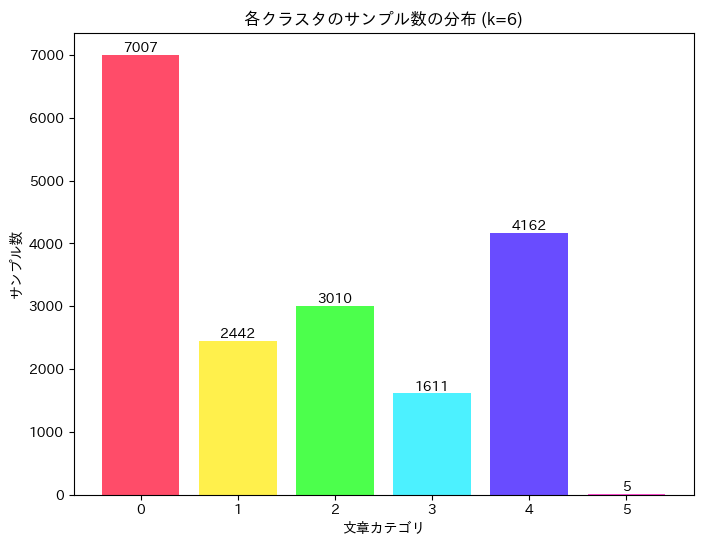

In [202]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
import numpy as np

# 日本語フォントの設定
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# 各クラスの度数を計算
unique_clusters, counts = np.unique(clusters, return_counts=True)

# カラーマップを取得
cmap_name = 'gist_rainbow'
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0, 1, len(unique_clusters)))

# 可視化
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_clusters, counts, color=colors, alpha=0.7)
plt.xlabel('文章カテゴリ')
plt.ylabel('サンプル数')
plt.title(f'各クラスタのサンプル数の分布 (k={k})')
plt.xticks(unique_clusters)

# テキストを表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

## クラスター数の決定

### エルボー法による最適クラスター数の調査
エルボー法では、SSE値(残差平方和)が急激に減少している部分において、SSE値が最も小さい点が最適なクラスター数であると判断する

In [203]:
'''
# エルボー法による最適クラスター数の調査
SSE = []
for i in range(1, 40):
    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    SSE.append(kmeansModel.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(1, 40), SSE, marker='o', markersize=3)
plt.xlabel('クラスター数')
plt.ylabel('SSE')
plt.title('エルボー法による最適クラスター数の調査')
plt.show()
'''


"\n# エルボー法による最適クラスター数の調査\nSSE = []\nfor i in range(1, 40):\n    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    SSE.append(kmeansModel.inertia_)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(1, 40), SSE, marker='o', markersize=3)\nplt.xlabel('クラスター数')\nplt.ylabel('SSE')\nplt.title('エルボー法による最適クラスター数の調査')\nplt.show()\n"

### シルエット係数による最適クラスター数の調査

In [204]:
'''
from sklearn.metrics import silhouette_score

# シルエット係数による最適クラスター数の調査
silhouette_coefficients = []
for i in range(2, 40):
    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    silhouette_coefficient = silhouette_score(df_embeddings, kmeansModel.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, 40), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('クラスター数')
plt.ylabel('シルエット係数の平均値')
plt.title('シルエット係数の平均値による最適クラスター数の調査')
plt.show()
'''

"\nfrom sklearn.metrics import silhouette_score\n\n# シルエット係数による最適クラスター数の調査\nsilhouette_coefficients = []\nfor i in range(2, 40):\n    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    silhouette_coefficient = silhouette_score(df_embeddings, kmeansModel.labels_) # シルエット係数の平均値\n    silhouette_coefficients.append(silhouette_coefficient)\n\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, 40), silhouette_coefficients, marker='o', markersize=3)\nplt.xlabel('クラスター数')\nplt.ylabel('シルエット係数の平均値')\nplt.title('シルエット係数の平均値による最適クラスター数の調査')\nplt.show()\n"

### シルエット図

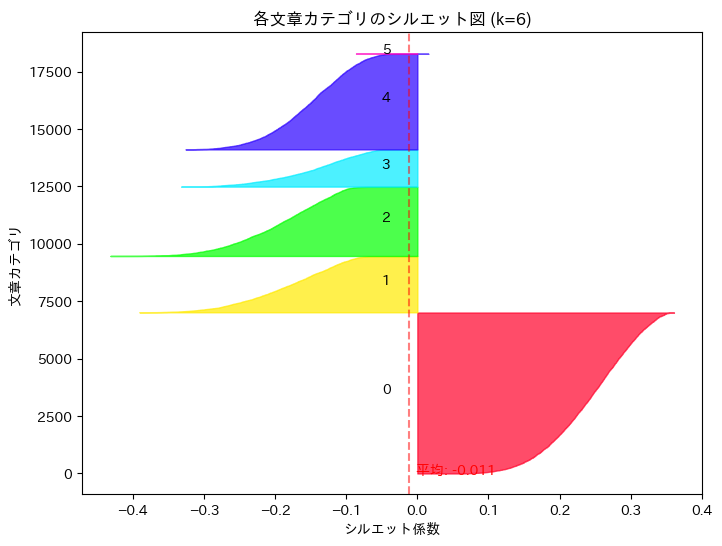

In [205]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_embeddings, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_embeddings, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"平均: {silhouette_avg:.3f}", color="red")

plt.xlabel('シルエット係数')
plt.ylabel('文章カテゴリ')
plt.title(f'各文章カテゴリのシルエット図 (k={k})')
plt.show()

In [206]:
# 各文章カテゴリのシルエット係数が最も高い文章を表示
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
    print('---')

文章カテゴリ: 0
シルエット係数が最も高い文章: きもちわるい
シルエット係数: 0.361
---
文章カテゴリ: 1
シルエット係数が最も高い文章: なるようになる、なるようにしかならない。好きな人を信じて何が悪い。恋をして何が悪い。\n\n思い出すたび泣きそうになるけど、例え騙されたって嘘つかれたってわたしはきちんと真っ直ぐを向いて恋をしていたんだよ。全部信じていたんだよ。あの時、それの何がいけなかったんだろうね？
シルエット係数: -0.057
---
文章カテゴリ: 2
シルエット係数が最も高い文章: ここへきて色々落ち込むことがあるみたいだ。今まで、できることを褒めまくってきて、あまり出来ないことを指摘してこなかった。他人と比べて自分が出来ない事があることを知ったり、頑張っても報われない理不尽こそ世の中、と思えばそうなのかもだけど、親も心が痛いな。
シルエット係数: -0.071
---
文章カテゴリ: 3
シルエット係数が最も高い文章: ティッシュひと家族ひとつまでなのに2つ買ってるご老人………………………………お前みたいなののせいでな…………………………………………………………… 
シルエット係数: -0.004
---
文章カテゴリ: 4
シルエット係数が最も高い文章: ウワァーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
シルエット係数: 0.016
---
文章カテゴリ: 5
シルエット係数が最も高い文章: プリコネ始めたんだけど確かにこれはすごいサクサクで良いなー！めんどくさくない！あとキャラがみんな可愛い！！まずコッコロ(ナビ役)がうるさくなくて従順なのがポイント高いし、タイトル画像にもなってるペコリーヌが敬語でキャピキャピうるさい食いしん坊キャラなの、とてもとても良い…可愛い…
シルエット係数: -0.057
---


In [207]:
# 特定の文章カテゴリのシルエット係数が高い上位5件を表示
target_cluster = 3
cluster_silhouette_values = silhouette_values[clusters == target_cluster]
cluster_silhouette_values.sort()
for i in range(5):
    index = np.where(silhouette_values == cluster_silhouette_values[-i - 1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-i - 1]:.3f}')
    print('---')

文章カテゴリ: 3
シルエット係数が高い文章: ティッシュひと家族ひとつまでなのに2つ買ってるご老人………………………………お前みたいなののせいでな…………………………………………………………… 
シルエット係数: -0.004
---
文章カテゴリ: 3
シルエット係数が高い文章: 劇場版ラブライブ!の上映から既に5年経ってるとかいうヤバ事実ほんとやめてくれ………………………………………。
シルエット係数: -0.039
---
文章カテゴリ: 3
シルエット係数が高い文章: 宣伝会議、締め切りを盛大に勘違いしていて応募できなかった…でも考えるの超楽しかったから…ただただ馬鹿だった…そういえば夏休みの宿題もギリギリなタイプやったで自分……そういうとこやぞいい加減にしろよ自分…
シルエット係数: -0.045
---
文章カテゴリ: 3
シルエット係数が高い文章: ソースが古いので、ざっくりな話ですが…\n\n全世界のツイート数:1日5億件以上\n日本人のツイート数:1日5千万件（全体の10%と仮定）\n\nニュースで取り上げられるのは、多くても1日100件くらい？かなと思うので…\n\nニュースに取り上げられる確率は、0.0002%か！\n\n取り上げられるって、凄い！！
シルエット係数: -0.050
---
文章カテゴリ: 3
シルエット係数が高い文章: お給料貰ったのは出勤してすぐで、その時は『しばらく一人でやろうと思ってて…』と言ってたので、あーまたパート休みが続くのねと思っていたんだけれど、帰る時に『一旦退職ということで…、3年間ありがとうございました』って言われて、そっち！？ってなった。
シルエット係数: -0.050
---


## クラスタリング結果の可視化

### PCA

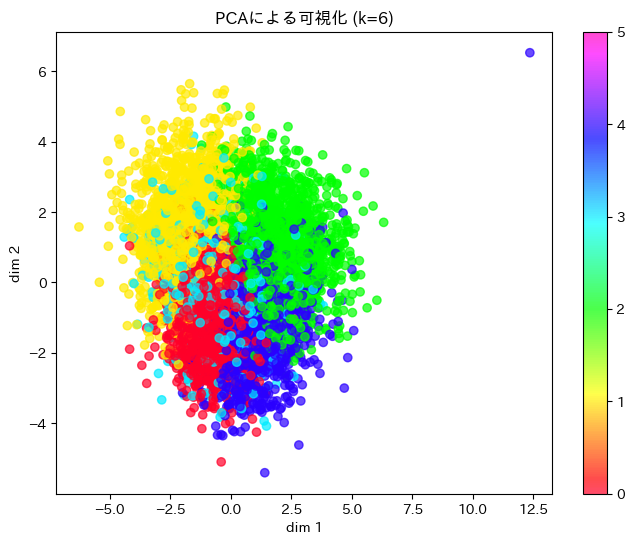

In [208]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca.fit(df_embeddings)
df_embeddings_pca = pca.transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_embeddings_pca[:, 0], df_embeddings_pca[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'PCAによる可視化 (k={k})')
plt.colorbar()
plt.show()

### t-SNE

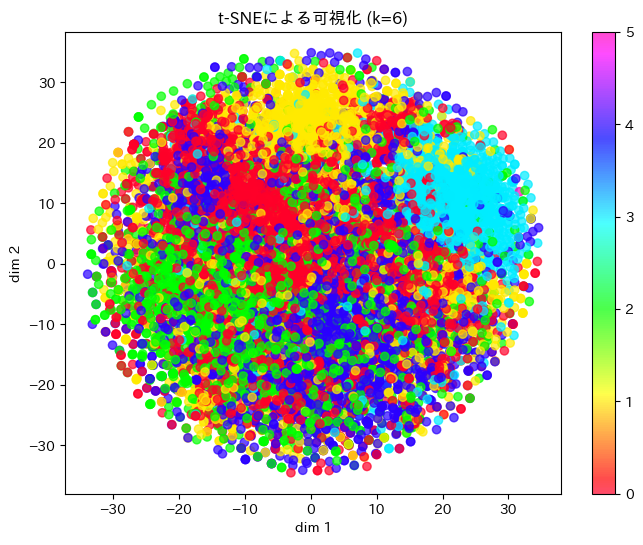

In [209]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
df_wrime_features_tsne = tsne.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNEによる可視化 (k={k})')
plt.colorbar()
plt.show()

# in 1min

### UMAP

In [210]:
'''
import umap

# UMAP
umap_obj = umap.UMAP(n_components=2, random_state=0)
df_wrime_features_umap = umap_obj.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'UMAPによる可視化 (k={k})')
plt.colorbar()
plt.show()
'''

"\nimport umap\n\n# UMAP\numap_obj = umap.UMAP(n_components=2, random_state=0)\ndf_wrime_features_umap = umap_obj.fit_transform(df_embeddings)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)\nplt.xlabel('dim 1')\nplt.ylabel('dim 2')\nplt.title(f'UMAPによる可視化 (k={k})')\nplt.colorbar()\nplt.show()\n"

---

# 感情カテゴリとつぶやき分散表現の関係

In [211]:
# clusters/emotion_6clusters.tsvを読み込み
df_clusters = pd.read_csv('clusters/emotion_6clusters.tsv', sep='\t', header=None)
# 変換
emotion_clusters = df_clusters[0].tolist()
emotion_clusters = [int(x) for x in emotion_clusters]
df_emotion_clusters = pd.DataFrame(emotion_clusters, columns=['labels'])

In [212]:
df_emotion_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  18237 non-null  int64
dtypes: int64(1)
memory usage: 142.6 KB


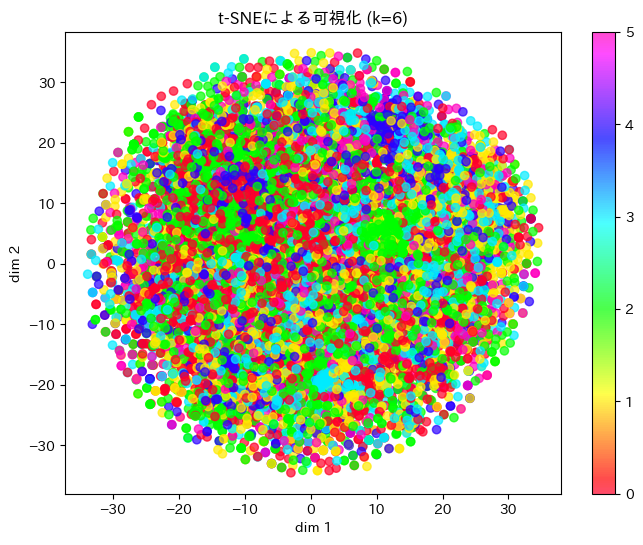

In [213]:
# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNEによる可視化 (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

---

### 感情カテゴリを正解ラベルとして、つぶやき分散表現から学習

In [214]:
# df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clustersを結合
df_embeddings_clusters = pd.concat([df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clusters], ignore_index=True, axis=1)
df_embeddings_clusters


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,769
0,train,-0.381713,-0.414190,0.212680,-0.600458,-0.315123,0.043852,-0.063573,0.473792,0.300267,...,-0.176696,0.622916,0.122309,-0.054005,0.622500,0.422048,-0.800622,0.231044,-0.247871,1
1,train,0.232761,-0.128775,0.058888,-0.793445,-0.214974,-0.697416,-0.166957,0.566010,-0.740453,...,-0.178906,-0.100266,0.562408,-0.292500,-0.881694,0.032853,0.109639,0.751052,-0.097353,4
2,train,0.548168,-0.714308,0.318142,0.509349,-0.472402,-0.137803,0.006984,0.083369,0.037084,...,0.304661,-0.755946,-0.595817,-0.519947,-0.382004,0.106388,0.147297,-0.329164,-0.091143,0
3,train,-0.098861,0.062569,0.299713,-0.055591,-0.212316,-0.028156,0.223011,0.526357,0.108861,...,-0.067468,0.042400,-0.167523,-0.027520,0.315066,0.271988,0.005288,0.220970,-0.108485,2
4,train,-0.897976,0.002503,0.844819,-0.231315,-0.364698,0.355721,0.254712,0.070709,0.390042,...,0.397795,0.620714,-0.234214,0.263276,0.983235,0.373972,0.324229,-0.486923,-0.616886,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,train,-0.584110,-0.145722,-0.047173,-0.260154,-0.249326,-0.024467,-0.213487,0.524912,-0.121891,...,-0.060212,-0.013044,-0.784054,0.669356,0.424457,0.826959,-0.177964,0.115120,-0.237495,0
18233,train,0.158032,-0.288453,0.064470,0.023490,-0.678537,0.082319,0.019249,0.691907,-0.377085,...,-0.388144,-0.433288,-0.106059,-0.924372,-0.934127,0.851125,-0.051323,0.589329,-0.526685,2
18234,train,-0.040791,-0.104001,-1.059067,-0.473647,0.217490,0.033151,-0.739289,-0.002070,0.443143,...,-0.374587,1.361471,-0.862501,-0.543221,0.442671,0.238492,0.173678,-0.381204,-0.090209,0
18235,train,-0.657572,0.192015,-0.261624,0.245431,0.149139,-0.442141,-1.052307,0.079886,-0.046505,...,-0.383316,0.175034,0.374631,-0.178508,0.399008,0.197688,-0.774340,-0.193142,-0.584466,2


In [215]:
# train / test に分割する
df_groups = df_embeddings_clusters.groupby(0)
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

train : 17104
test : 1133


In [216]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,769
0,train,-0.381713,-0.414190,0.212680,-0.600458,-0.315123,0.043852,-0.063573,0.473792,0.300267,...,-0.176696,0.622916,0.122309,-0.054005,0.622500,0.422048,-0.800622,0.231044,-0.247871,1
1,train,0.232761,-0.128775,0.058888,-0.793445,-0.214974,-0.697416,-0.166957,0.566010,-0.740453,...,-0.178906,-0.100266,0.562408,-0.292500,-0.881694,0.032853,0.109639,0.751052,-0.097353,4
2,train,0.548168,-0.714308,0.318142,0.509349,-0.472402,-0.137803,0.006984,0.083369,0.037084,...,0.304661,-0.755946,-0.595817,-0.519947,-0.382004,0.106388,0.147297,-0.329164,-0.091143,0
3,train,-0.098861,0.062569,0.299713,-0.055591,-0.212316,-0.028156,0.223011,0.526357,0.108861,...,-0.067468,0.042400,-0.167523,-0.027520,0.315066,0.271988,0.005288,0.220970,-0.108485,2
4,train,-0.897976,0.002503,0.844819,-0.231315,-0.364698,0.355721,0.254712,0.070709,0.390042,...,0.397795,0.620714,-0.234214,0.263276,0.983235,0.373972,0.324229,-0.486923,-0.616886,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,train,-0.584110,-0.145722,-0.047173,-0.260154,-0.249326,-0.024467,-0.213487,0.524912,-0.121891,...,-0.060212,-0.013044,-0.784054,0.669356,0.424457,0.826959,-0.177964,0.115120,-0.237495,0
18233,train,0.158032,-0.288453,0.064470,0.023490,-0.678537,0.082319,0.019249,0.691907,-0.377085,...,-0.388144,-0.433288,-0.106059,-0.924372,-0.934127,0.851125,-0.051323,0.589329,-0.526685,2
18234,train,-0.040791,-0.104001,-1.059067,-0.473647,0.217490,0.033151,-0.739289,-0.002070,0.443143,...,-0.374587,1.361471,-0.862501,-0.543221,0.442671,0.238492,0.173678,-0.381204,-0.090209,0
18235,train,-0.657572,0.192015,-0.261624,0.245431,0.149139,-0.442141,-1.052307,0.079886,-0.046505,...,-0.383316,0.175034,0.374631,-0.178508,0.399008,0.197688,-0.774340,-0.193142,-0.584466,2


In [217]:
import xgboost as xgb

# xgboostの入力データを作成
train_data = df_train.drop([0, vector_size+1], axis=1).values
train_labels = df_train[vector_size+1].values

test_data = df_test.drop([0, vector_size+1], axis=1).values
test_labels = df_test[vector_size+1].values

train_data = xgb.DMatrix(train_data, label=train_labels)
test_data = xgb.DMatrix(test_data, label=test_labels)

[0]	train-mlogloss:1.75423	test-mlogloss:1.73998
[1]	train-mlogloss:1.72671	test-mlogloss:1.70291
[2]	train-mlogloss:1.70581	test-mlogloss:1.67274
[3]	train-mlogloss:1.68947	test-mlogloss:1.65124
[4]	train-mlogloss:1.67609	test-mlogloss:1.63359
[5]	train-mlogloss:1.66468	test-mlogloss:1.61704
[6]	train-mlogloss:1.65476	test-mlogloss:1.60495
[7]	train-mlogloss:1.64604	test-mlogloss:1.59300
[8]	train-mlogloss:1.63805	test-mlogloss:1.58321
[9]	train-mlogloss:1.63063	test-mlogloss:1.57407
[10]	train-mlogloss:1.62360	test-mlogloss:1.56409
[11]	train-mlogloss:1.61704	test-mlogloss:1.55698
[12]	train-mlogloss:1.61079	test-mlogloss:1.55219
[13]	train-mlogloss:1.60477	test-mlogloss:1.54597
[14]	train-mlogloss:1.59898	test-mlogloss:1.54133
[15]	train-mlogloss:1.59330	test-mlogloss:1.53588
[16]	train-mlogloss:1.58785	test-mlogloss:1.53178
[17]	train-mlogloss:1.58260	test-mlogloss:1.52578
[18]	train-mlogloss:1.57750	test-mlogloss:1.52262
[19]	train-mlogloss:1.57258	test-mlogloss:1.51609
[20]	train

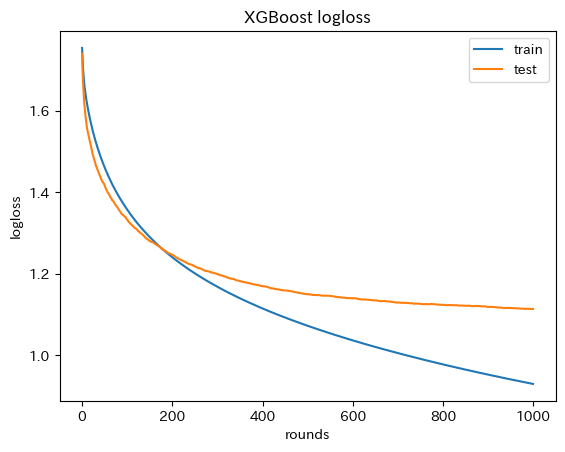

In [218]:
# モデル
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(emotion_clusters)),
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 0,
    'max_depth': 1,
    'eta': 0.3,
}

history = dict()

# 学習
model = xgb.train(params, train_data, evals=[(train_data, 'train'), (test_data, 'test')], evals_result=history, num_boost_round=1000, early_stopping_rounds=30)

# 予測
preds_labels = model.predict(test_data)

# グラフ描写
plt.plot(history['train']['mlogloss'], label='train')
plt.plot(history['test']['mlogloss'], label='test')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.legend()
plt.show()

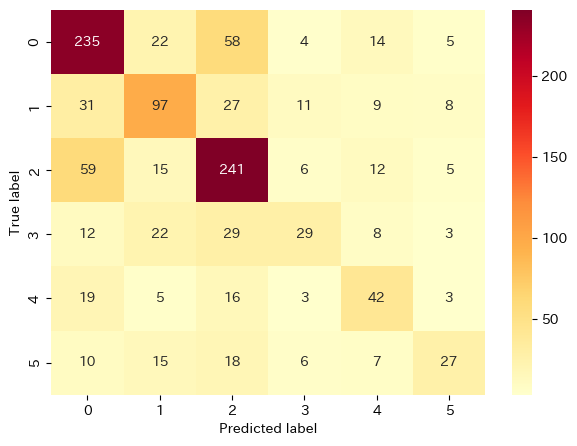

              precision    recall  f1-score   support

           0      0.642     0.695     0.668       338
           1      0.551     0.530     0.540       183
           2      0.620     0.713     0.663       338
           3      0.492     0.282     0.358       103
           4      0.457     0.477     0.467        88
           5      0.529     0.325     0.403        83

    accuracy                          0.592      1133
   macro avg      0.548     0.504     0.516      1133
weighted avg      0.584     0.592     0.583      1133



In [219]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 混同行列の作成
cm = confusion_matrix(test_labels, preds_labels, labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 各クラスの適合率、再現率、F1スコアを算出
print(classification_report(test_labels, preds_labels, digits=3))

In [220]:
# 間違って予測された文章のindexを取得
wrong_preds = np.where(test_labels != preds_labels)[0]

# 間違って予測された文章を5個表示
for i in wrong_preds[10:15]:
    print(df_wrime_target.iloc[i]['Sentence'])
    print('True label:', test_labels[i])
    print('Predicted label:', preds_labels[i])
    print('---')

友達がハワイで挙式して、森で撮った写真がすごく素敵で羨ましかった。長い髪はゆる巻きダウンにして、お花の冠とベールをつけてるかんじ。木漏れ日を見上げる姿が可愛かったなぁ。
True label: 0
Predicted label: 4.0
---
｢悪の教典｣観てきた。体温と心拍の異常いまだやまず…握りしめすぎて手がしびれてる。
True label: 0
Predicted label: 4.0
---
ホットカーペットに寝っ転がってうとうとするのサイコー。
True label: 3
Predicted label: 1.0
---
久しぶりにヤツが来た。ちきしょう、油断してた…コルセット生活、再開!!(T_T)
True label: 3
Predicted label: 1.0
---
終わった…音楽は終わらない、その通りだ！君がッ！泣くまで！音楽を愛すのを、辞めない…！
True label: 4
Predicted label: 0.0
---
